#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2*np.pi*1*x)*8.+9.0 #*np.sin(2*np.pi*3*x+.6)

(100, 2)


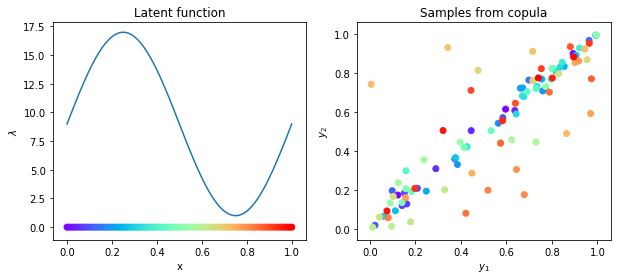

In [3]:
# here we generate some synthetic samples
import matplotlib.cm as cm

NSamp = int(1e2)

X = np.linspace(0.,1.,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

# Y = np.zeros((NSamp,2))
# copula = GaussCopula()
# for i,x in enumerate(X):
#     if scale(x) == 0:
#         Y[i] = np.random.uniform(low=0,high=1,size=2)
#     else:
#         Y[i] = np.array(copula.sample(1,scale(x))).T # size=1
scales = [scale(x) for x in X]
model = GumbelCopula(torch.tensor(scales).float())
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0., 1., NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from copula')

fig.show()

In [4]:
Y[Y == float("inf")]

array([], dtype=float32)

In [5]:
Y[Y == float('nan')]

array([], dtype=float32)

In [6]:
(np.min(Y),np.max(Y))

(0.005825774, 0.9955089)

In [7]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float()#.cuda(device=0)
train_y = torch.tensor(Y).float()#.cuda(device=0)

In [8]:
class KISS_GPInferenceModel2(gpytorch.models.PyroVariationalGP):
    def __init__(self, likelihood, prior_rbf_length=0.1, grid_size=128, grid_bounds=[(0, 1)], name_prefix="mixture_gp"):
        # Define all the variational stuff
        variational_distribution = CholeskyVariationalDistribution(grid_size)
        variational_strategy = gpytorch.variational.GridInterpolationVariationalStrategy(
            self, grid_size, grid_bounds, variational_distribution
        )
        
        # Standard initializtation
        super(KISS_GPInferenceModel2, self).__init__(variational_strategy, likelihood, num_data=grid_size) #?
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()#prior = gpytorch.priors.NormalPrior(14.,14.0))
        
        #we specify prior here
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 1.0) #variance does not matter much
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
        )
        
        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [9]:
f=torch.tensor([1.4])
(torch.sigmoid(2.*f)-0.5)*34.0

tensor([15.0510])

In [10]:
# define the model (optionally on GPU)
grid_size = 128
#model = GPInferenceModel(train_x, train_y, GaussianCopula_Likelihood())#.cuda(device=0)
model = KISS_GPInferenceModel(GumbelCopula_Likelihood(), prior_rbf_length=0.5, grid_size=grid_size)#.cuda(device=0)

In [11]:
# train the model
from pyro import optim

base_lr = 1e-3
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# set learning rates for different hyperparameters
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": .05} #.1 for 256 particles
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": .1}
    else:
        #print(param_name)
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

pyro.clear_param_store() # clean run

losses, rbf, means = [], [], []

def train(num_iter=2000):
    elbo = pyro.infer.Trace_ELBO(num_particles=128, vectorize_particles=True, max_plate_nesting=1)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    p = 0.
    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy().copy())
        if not (i + 1) % iter_print:
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}, dLoss: {:.3}, mean f: {:.3}, dmean: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(), mean_p/np.abs(loss), np.mean(means[-1]), np.mean(np.abs(1-means[-100]/means[-1]))
            ))
            
            #print(np.std(losses[-100:]))
            if (0 < mean_p/np.abs(loss) < 0.01):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.
        
%time train()

Basic lr for most of parameters: 0.001
Iter 100/2000 - Loss: -86.8   lengthscale: 0.42, dLoss: 0.0, mean f: 0.0593, dmean: 7.18
Iter 200/2000 - Loss: -95.1   lengthscale: 0.424, dLoss: 0.138, mean f: 0.181, dmean: 0.963
Iter 300/2000 - Loss: -1.07e+02   lengthscale: 0.398, dLoss: 0.0459, mean f: 0.353, dmean: 2.31
Iter 400/2000 - Loss: -1.2e+02   lengthscale: 0.367, dLoss: 0.0518, mean f: 0.557, dmean: 0.395
Iter 500/2000 - Loss: -1.3e+02   lengthscale: 0.335, dLoss: 0.0489, mean f: 0.764, dmean: 0.499
Iter 600/2000 - Loss: -1.39e+02   lengthscale: 0.306, dLoss: 0.0362, mean f: 0.947, dmean: 0.403
Iter 700/2000 - Loss: -1.44e+02   lengthscale: 0.28, dLoss: 0.0227, mean f: 1.09, dmean: 0.228
Iter 800/2000 - Loss: -1.48e+02   lengthscale: 0.26, dLoss: 0.015, mean f: 1.21, dmean: 0.213
Iter 900/2000 - Loss: -1.51e+02   lengthscale: 0.244, dLoss: 0.00938, mean f: 1.3, dmean: 0.18
Converged!
CPU times: user 30min 32s, sys: 3min 14s, total: 33min 46s
Wall time: 1min 56s


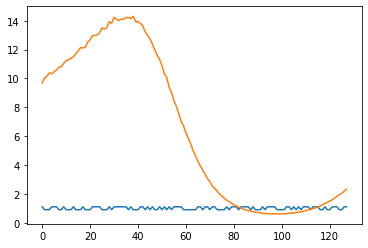

In [12]:
plt.plot(np.exp(means[0]))
plt.plot(np.exp(means[-1]))
losses[losses!=losses] = 0

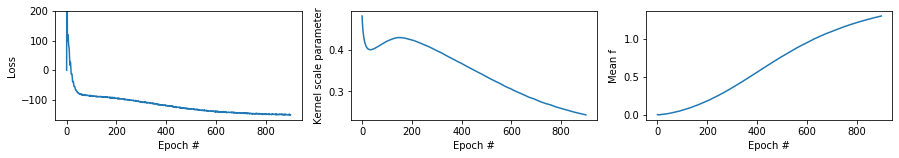

In [13]:
# prot loss function and kernel length
fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
loss.set_ylim(np.min(losses)*1.1,200)
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [14]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float()#.cuda(device=0)

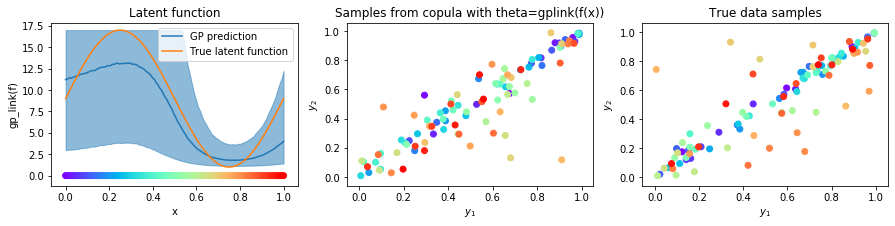

In [15]:
# visualize the result
fig, (func, sim, true) = plt.subplots(1,3,figsize=(15, 3))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
 
samples = output.rsample(torch.Size([2048]))
F_mean = gplink(samples).mean(0).detach().cpu().numpy()
#F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
skip = 1
true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
sim.scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula with theta=gplink(f(x))')
true.set_title('True data samples')
# samp.legend()

fig.show()